# Analysis of MERFISH data

## Setup
You will work on a MERFISH mouse brain dataset generated by members of the SpaceTx consoritum, the data can be downloaded by running the script `merfish_downloader.sh`. The URLs in the scripts are taken from [this github page](https://github.com/spacetx-spacejam/data), which contains other interesting spatial datasets you can explore.

We import the standard data science stack `pandas` and `numpy`, and the plotting package `matplotlib.pyplot`. We import also the outer package `matplotlib` as we will need some low-level plot tweaking.
The package `json` is required as one file from the spatial dataset we will work on has been stored in the `json` format.

In [2]:
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import json
import matplotlib
import matplotlib.pyplot as plt

For cool plots, don't forget the dark theme in Jupyter Notebook/JupyterLab ;-)

In [4]:
plt.style.use('dark_background')

The data we downloaded looks like this, let's expore it!
```
./data/merfish/
|-- Allen_MERFISH_Layers.geojson
|-- Allen_MERFISH_spots_with_anatomy.csv
|-- fixed_1001844875.csv
`-- MERFISH_genes.csv
```

## Loading the MERFISH spots

In [5]:
df = pd.read_csv('data/merfish/Allen_MERFISH_spots_with_anatomy.csv')

In [6]:
df.shape

(3841412, 7)

In [7]:
df.iloc[:10]

Unnamed: 0.1  Unnamed: 0         x_um         y_um  gene     depth_um  \
0             0           0  1278.683956  6020.642260  Gad2  1445.701599   
1             1           1  1326.970330  6023.884788  Gad2  1403.168094   
2             2           2  1292.026844  6059.337093  Gad2  1413.731426   
3             3           3  1300.886241  6097.786264  Gad2  1385.680938   
4             4           4  1232.410068  6102.884182  Gad2  1440.812721   
5             5           5  1239.018739  6112.164763  Gad2  1430.264991   
6             6           6  1242.494357  6112.306423  Gad2  1427.252525   
7             7           7  1233.548817  6113.698880  Gad2  1434.066228   
8             8           8  1238.239219  6114.846423  Gad2  1429.489336   
9             9           9  1350.081409  6124.715898  Gad2  1329.710342   

          layer  
0  outside_VISp  
1  outside_VISp  
2  outside_VISp  
3  outside_VISp  
4  outside_VISp  
5  outside_VISp  
6  outside_VISp  
7  outside_VISp  
8  outside_VISp  
9  outside_VISp

The data seems to be 3D, let's look at the distribution of the coordinate values

/tmp/ipykernel_84915/2343443695.py:4: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend((im0, im1, im2), labels=('depth', 'x', 'y'), loc='upper right')


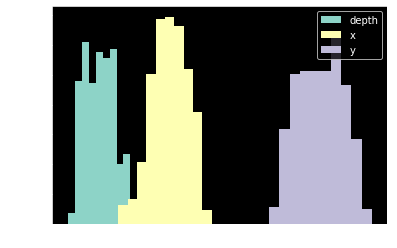

In [9]:
im0 = plt.hist(df.depth_um)
im1 = plt.hist(df.x_um)
im2 = plt.hist(df.y_um)
plt.legend((im0, im1, im2), labels=('depth', 'x', 'y'), loc='upper right')
plt.show()

Looks like that the first two columns are not informative, let's verify this, and then drop them.

In [7]:
print(df.index == df.iloc[:, 0])
print(np.all(df.index == df.iloc[:, 0]))
print(np.all(df.index == df.iloc[:, 1]))
df.drop(columns=[df.columns[0], df.columns[1]], inplace=True)
df

[ True  True  True ...  True  True  True]
True
True


x_um         y_um  gene     depth_um         layer
0        1278.683956  6020.642260  Gad2  1445.701599  outside_VISp
1        1326.970330  6023.884788  Gad2  1403.168094  outside_VISp
2        1292.026844  6059.337093  Gad2  1413.731426  outside_VISp
3        1300.886241  6097.786264  Gad2  1385.680938  outside_VISp
4        1232.410068  6102.884182  Gad2  1440.812721  outside_VISp
...              ...          ...   ...          ...           ...
3841407  3161.427603  5192.594981  Mup5   297.777986  outside_VISp
3841408  3099.698528  5221.596008  Mup5   334.424115  outside_VISp
3841409  3084.582240  5297.234605  Mup5   306.740686  outside_VISp
3841410  3054.192051  5342.142346  Mup5   308.399438   VISp_II/III
3841411  3058.963217  5348.150185  Mup5   301.154743   VISp_II/III

[3841412 rows x 5 columns]

### Plotting all the spots

Since we have millions of points we need a small value of `alpha` (color transparency), and `s` (spot size).

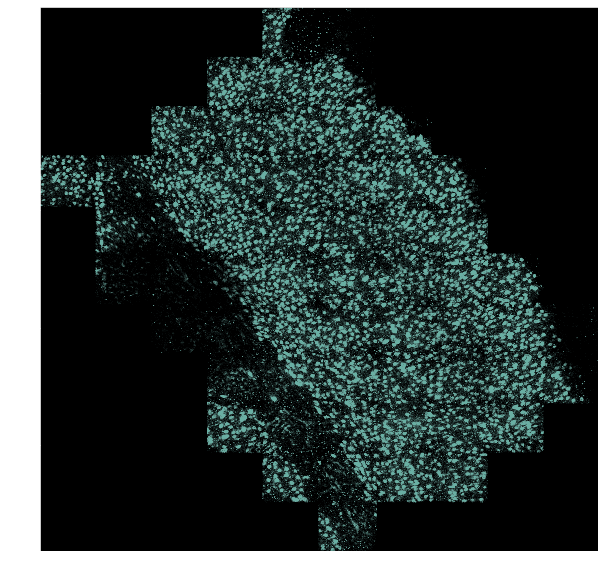

In [10]:
df_slice = df
# df_slice = df[(df['depth_um'] > 1000) & (df['depth_um'] < 1100)]

plt.figure(figsize=(10, 10))
plt.scatter(df_slice['x_um'], df_slice['y_um'], alpha=0.1, s=0.01)
plt.xlim(df['x_um'].min(), df['x_um'].max())
plt.ylim(df['y_um'].min(), df['y_um'].max())
plt.show()

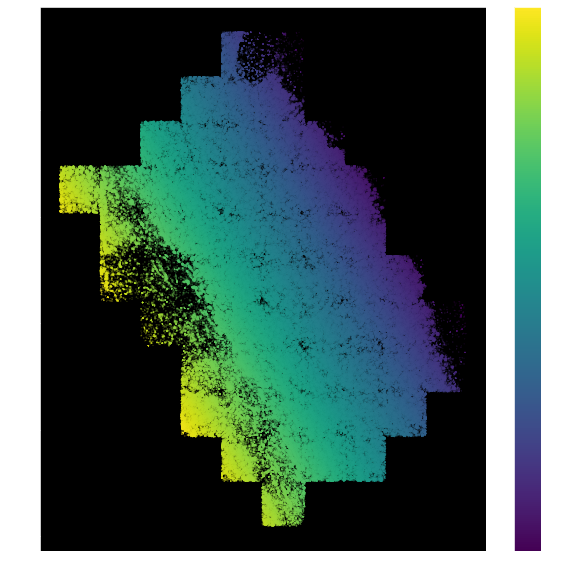

In [13]:
if False:
    plt.figure(figsize=(10, 10))
    plt.scatter(df['x_um'], df['y_um'], alpha=1, s=0.01, c=df['depth_um'].to_numpy())
    plt.colorbar()
    plt.show()

From the above plot we see that we have 3D coordinates, but what we have is a 2D surface embedded in the 3D space. So in this case, *for simplicity*, we can proceed the analysis just considering the x and y coordinates.

In the case we want to explore the points with an external 3D visualizer

In [14]:
if False:
    points = np.vstack((df['x_um'].to_numpy(), df['y_um'].to_numpy(), df['depth_um'].to_numpy())).T
    print(points.shape)
    np.save('data/3d.npy', points)

(3841412, 3)


### Plotting the spots of a smaller region, colored by gene

In [17]:
genes = df['gene'].unique()
print(len(genes))
genes

268


array(['Gad2', 'Penk', 'Rab3b', 'Tac2', '1700022I11Rik', '1810046K07Rik',
       '5031425F14Rik', '5730522E02Rik', 'Acta2', 'Adam2', 'Adamts2',
       'Adamts4', 'Adra1b', 'Alk', 'Ano4', 'Aqp4', 'Asic4', 'B4galnt2',
       'B4galnt3', 'Barx2', 'Bcl11b', 'Bgn', 'Blank-10', 'Blank-2',
       'Blank-3', 'Blank-4', 'Blank-5', 'Blank-7', 'Blank-8', 'Blank-9',
       'Blnk', 'Bmpr1b', 'Brinp3', 'C1ql3', 'C1qtnf7', 'Cacng5', 'Calb2',
       'Camk2d', 'Car3', 'Cbln2', 'Cbln4', 'Ccbe1', 'Ccdc162', 'Ccdc3',
       'Ccdc80', 'Ccnb1', 'Cd14', 'Cd24a', 'Cdca7', 'Cdcp1', 'Cdh12',
       'Cdh13', 'Cdh20', 'Cdh9', 'Ceacam9', 'Cemip', 'Chat', 'Chn2',
       'Chodl', 'Chrm2', 'Chrna2', 'Cldn5', 'Clrn1', 'Cntnap5b', 'Cobll1',
       'Col14a1', 'Col15a1', 'Col24a1', 'Col25a1', 'Corin', 'Cplx3',
       'Crhr2', 'Crispld2', 'Cspg4', 'Ctss', 'Cux2', 'Cxcl14', 'Daam2',
       'Dmkn', 'Dscaml1', 'Egfem1', 'Egfr', 'Egln3', 'Egr2', 'Enpp6',
       'Epha7', 'Fam19a2', 'Fam84b', 'Fezf2', 'Flrt3', 'Flt1', 'Fndc7',


In [18]:
random_colors = [np.random.rand(3) for _ in genes]
colors_for_genes = dict(zip(genes, random_colors))

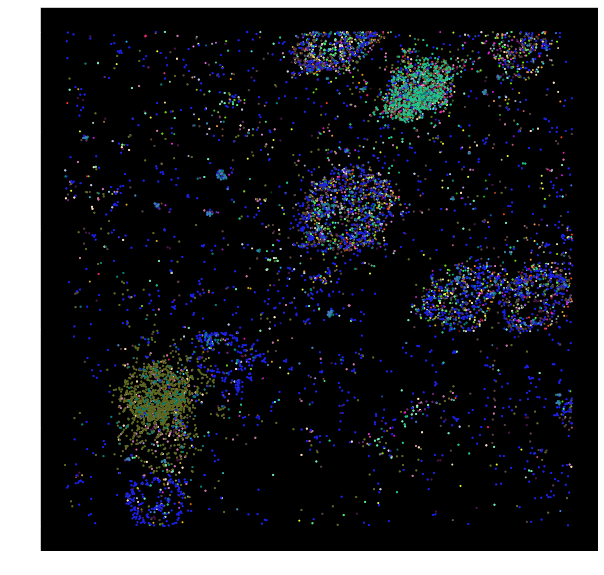

In [19]:
plt.figure(figsize=(10, 10))
smaller_df = df[
    (df['x_um'] > 2000) & 
    (df['x_um'] < 2100) &
    (df['y_um'] > 6000) &
    (df['y_um'] < 6100)
]

genes_colors_list = [colors_for_genes[gene] for gene in smaller_df['gene']]
plt.scatter(smaller_df['x_um'], smaller_df['y_um'], alpha=1, s=1, c=genes_colors_list)
plt.show()

We can appreciate what it looks like an enrichment of spots around cells; we'll verify later that this is actually the case.

### Plotting all the spots, colored by cortex layer

In [30]:
import seaborn as sns
tab10 = sns.color_palette('tab10') 
layers = df['layer'].unique()
print(layers)
print(len(layers))
# random_colors = [np.random.rand(3) for _ in layers]
colors_for_layers = dict(zip(layers, tab10))
tab10

['outside_VISp' 'VISp_wm' 'VISp_VI' 'VISp_V' 'VISp' 'VISp_IV'
 'VISp_II/III' 'VISp_I']
8


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

We need 8 colors, let's start from the palette tab10 and remove some colors that are too similar (why am I doing this? I made the plot with the standard tab10 and the colors were not good in this case)

In [29]:
print(tab10)
display(tab10)
tab10 = tab10[:4] + tab10[6:]
display(tab10)
print(len(tab10))

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

8


The if/else is to toggle on/off the code when running the whole notebook, since the execution takes a while (use the %%time magic command for benchmarking)

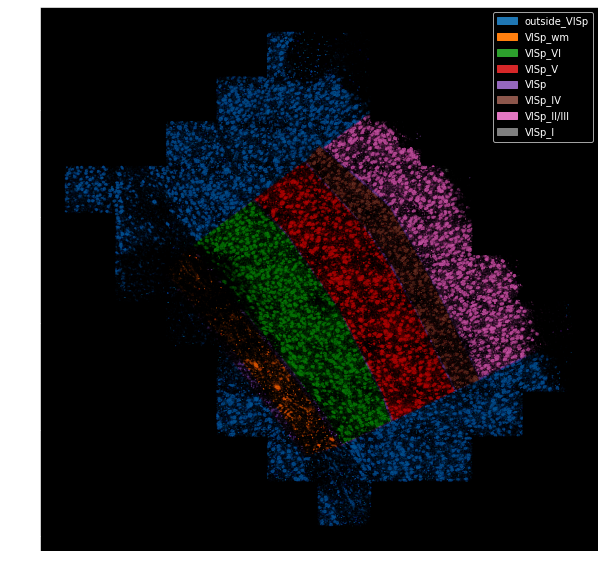

CPU times: user 50.9 s, sys: 2.94 s, total: 53.9 s
Wall time: 53.8 s


In [34]:
%%time
if False:
# if True:
    plt.figure(figsize=(10, 10))
    layers_colors_list = [colors_for_layers[layer] for layer in df['layer']]
    plt.scatter(df['x_um'], df['y_um'], alpha=0.1, s=0.01, c=layers_colors_list)
    layers_patches = [matplotlib.patches.Patch(color=color, label=layer_name) for layer_name, color in colors_for_layers.items()]
    plt.legend(handles=layers_patches)
    plt.show()

## Loading the layer data

We already have information on the cortex layers, but the data comes also with a geometric description of them, so let's have a look at that!

The `json` format is a human-readable way of storing information. When parsed it is automatically converted into a Python object of nested lists and dictionaries. This makes it very easy and convenient to store information, at the cost of slow performance for very large objects, for which a binary or indexed representation is preferred.

In [36]:
layers = json.load(open('data/merfish/Allen_MERFISH_Layers.geojson', 'r'))
layers

{'type': 'GeometryCollection',
 'geometries': [{'type': 'Polygon',
   'name': 'L1',
   'coordinates': [[[2435.069566, 6500.284703],
     [2476.390162, 6535.178868],
     [2534.993939, 6471.307336],
     [2743.287325, 6256.796237],
     [2892.512438, 6045.393994],
     [3110.132394, 5597.718655],
     [3175.960311, 5399.368749],
     [3130.896017, 5374.899385],
     [3077.489401, 5557.30352],
     [2850.542875, 6011.196572],
     [2712.19876, 6214.826674],
     [2493.024376, 6434.001058],
     [2435.069566, 6500.284703]]]},
  {'type': 'Polygon',
   'name': 'L4',
   'coordinates': [[[2099.296063, 6218.987584],
     [2143.972428, 6257.045228],
     [2145.859029, 6257.045228],
     [2146.338866, 6256.459168],
     [2151.558392, 6260.866921],
     [2210.003484, 6332.509292],
     [2221.323093, 6321.189682],
     [2222.09221, 6320.430889],
     [2259.341867, 6351.887251],
     [2357.789117, 6236.588669],
     [2668.674769, 5824.665181],
     [2827.226451, 5490.463105],
     [2914.2115, 5257.

In [37]:
layers.keys()

dict_keys(['type', 'geometries'])

In [38]:
brain_layers = {}
for layer in layers['geometries']:
    name = layer['name']
    coordinates = np.array(layer['coordinates'])
    coordinates = np.squeeze(coordinates, 0)
    brain_layers[name] = coordinates

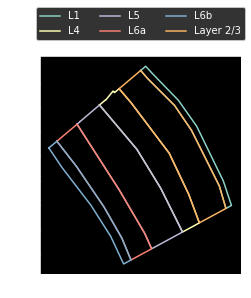

In [39]:
plt.figure()
for layer, coordinates in brain_layers.items():
    plt.plot(coordinates[:, 0], coordinates[:, 1])
plt.gca().set_aspect('equal')
plt.legend([layer for layer in brain_layers.keys()], loc='upper center', bbox_to_anchor=(.5, 1.25), ncol=3)
plt.show()

Let's plot the geometric boundaries along with the original spots.

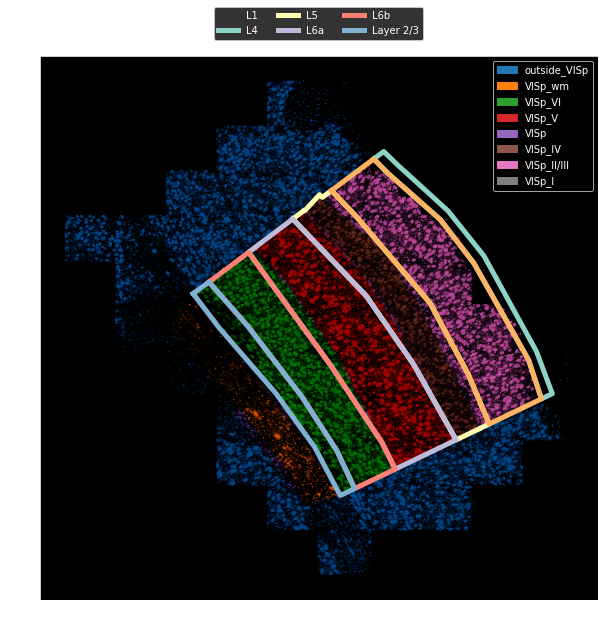

CPU times: user 46.1 s, sys: 2.51 s, total: 48.6 s
Wall time: 48.4 s


In [40]:
%%time
if False:
# if True:
    # N_POINTS = 10
    N_POINTS = len(df)

    plt.figure(figsize=(10, 10))
    colors_list = [colors_for_layers[layer] for layer in df['layer']]
    plt.scatter(df['x_um'][:N_POINTS], df['y_um'][:N_POINTS], alpha=0.1, s=0.01, c=colors_list[:N_POINTS])

    for layer, coordinates in brain_layers.items():
        plt.plot(coordinates[:, 0], coordinates[:, 1], linewidth=5)

    old_legend = plt.legend(handles=layers_patches)
    plt.legend([layer for layer in brain_layers.keys()], loc='upper center', bbox_to_anchor=(.5, 1.1), ncol=3)
    plt.gca().add_artist(old_legend)
    plt.show()

It seems that there is some mismatch between the boundaries. So let's ignore the geometric representation and proceeed with the annotations that come with the spot data.

## Loading the cell locations

The data comes already processed by estimating where the cells are and by assigning and counting the number of single-molecules (spots) beloning to each cell.

We don't have the full cell segmentation, just the center of the cells and their area, from which we will compute the radius.

In [41]:
df = pd.read_csv('data/merfish/fixed_1001844875.csv')
df.drop(columns=[df.columns[0], df.columns[1]], inplace=True)
df

1700022I11Rik  1810046K07Rik  5031425F14Rik  5730522E02Rik  Acta2  \
0                 0              0              0              0      0   
1                 0              0              1              1      0   
2                 0              0              0              1      0   
3                 0              0              0              0      2   
4                 0              0              0              1      0   
...             ...            ...            ...            ...    ...   
2394              0              0              0              0      3   
2395              0              0              0              0      6   
2396              0              1              0              1      3   
2397              1              0              0              0      0   
2398              0              0              0              0      0   

      Adam2  Adamts2  Adamts4  Adra1b  Alk  ...  Vwc2  Wipf3  Wnt7b  Zfp804b  \
0         0        0        0       1    1  ...     1      0      0        0   
1         0        0        0       0    0  ...     9      1      0        1   
2         0        0        0       0    0  ...     1      2      0        0   
3         0        0        0       0    0  ...     3      0      0        0   
4         0        0        2       0    0  ...     4      3      0        1   
...     ...      ...      ...     ...  ...  ...   ...    ...    ...      ...   
2394      1        0        0       0    0  ...     3      2      0        0   
2395      1        0        1       0    0  ...     1      3      1        1   
2396      2        0        3       0    0  ...     8      5      0        0   
2397      0        0        2       0    2  ...     2      0      0        0   
2398      0        0        0       0    0  ...     3      1      0        1   

        area                       position  total_reads  simpleClass  \
0     170.10  [1161.11337076 6178.3830543 ]          870           67   
1     206.55  [1162.91337076 6113.1330543 ]          454          233   
2     184.68  [1168.31337076 6046.0830543 ]          269           97   
3      87.48  [1163.81337076 6202.6830543 ]          340          105   
4     155.52  [1166.96337076 6083.8830543 ]          241           72   
...      ...                            ...          ...          ...   
2394  277.02  [3144.26337076 5201.4330543 ]         1062           96   
2395  200.07  [3154.61337076 5331.0330543 ]          188            0   
2396  338.58  [3165.41337076 5190.1830543 ]         1322           99   
2397  189.54  [3189.71337076 5292.7830543 ]          120           96   
2398  289.17  [3196.91337076 5196.9330543 ]          707           66   

             x_um         y_um  
0     1161.113371  6178.383054  
1     1162.913371  6113.133054  
2     1168.313371  6046.083054  
3     1163.813371  6202.683054  
4     1166.963371  6083.883054  
...           ...          ...  
2394  3144.263371  5201.433054  
2395  3154.613371  5331.033054  
2396  3165.413371  5190.183054  
2397  3189.713371  5292.783054  
2398  3196.913371  5196.933054  

[2399 rows x 274 columns]

In [48]:
import math
df['radius'] = df['area'].apply(lambda x: math.sqrt(x / math.pi))

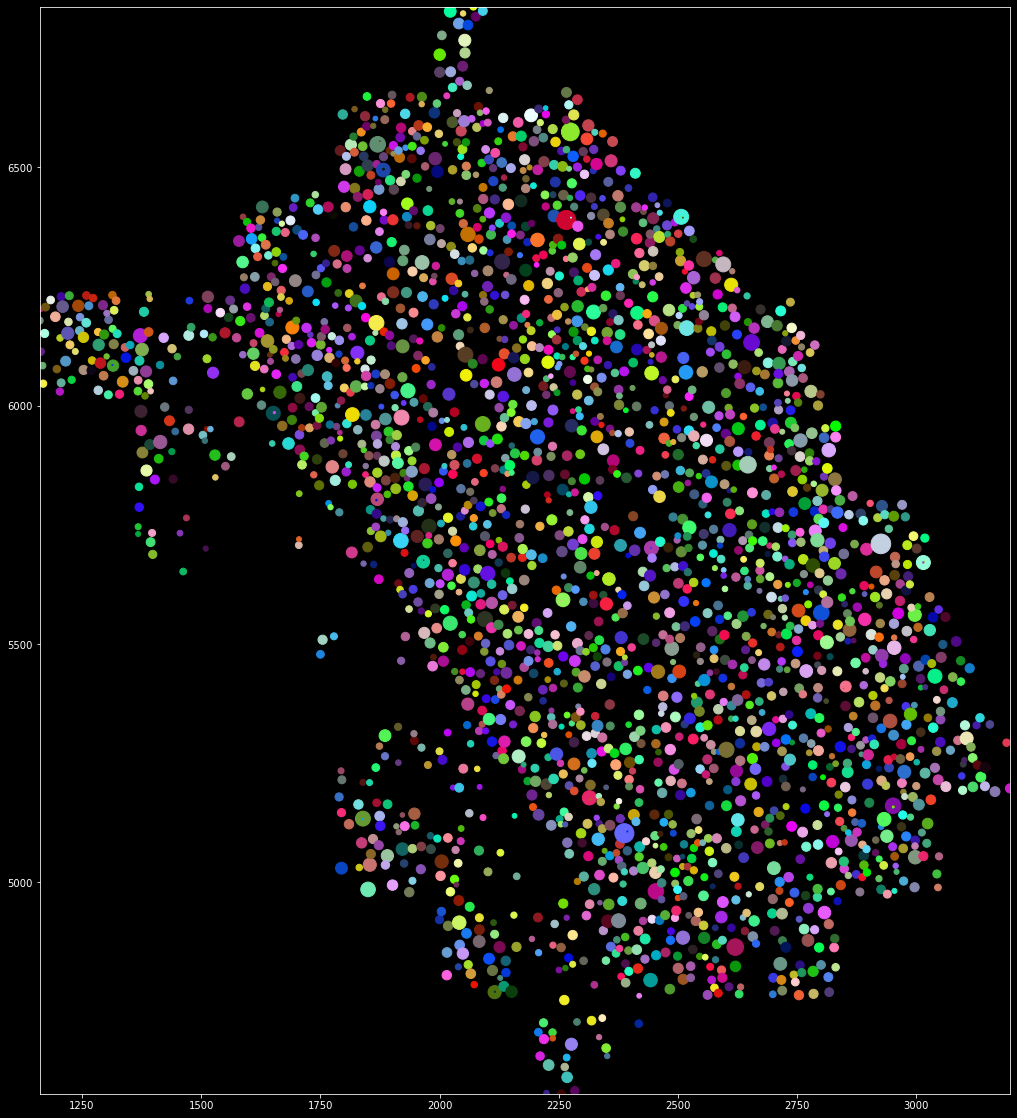

In [24]:
plt.figure(figsize=(20, 20))
# plt.scatter(df['x_um'], df['y_um'], s=df['radius'])
patches = []
for index, row in df.iterrows():
    patch = matplotlib.patches.Circle((row['x_um'], row['y_um']), row['radius'], color=np.random.rand(3))
    patches.append(patch)
p = matplotlib.collections.PatchCollection(patches, match_original=True)
ax = plt.gca()
ax.add_collection(p)
ax.set(
    xlim=(df['x_um'].min(), df['x_um'].max()),
    ylim=(df['y_um'].min(), df['y_um'].max())
)
ax.set_aspect('equal')
plt.show()

Let's plot cells and spots together, we expect some mismatch since we don't know the real cell shape.

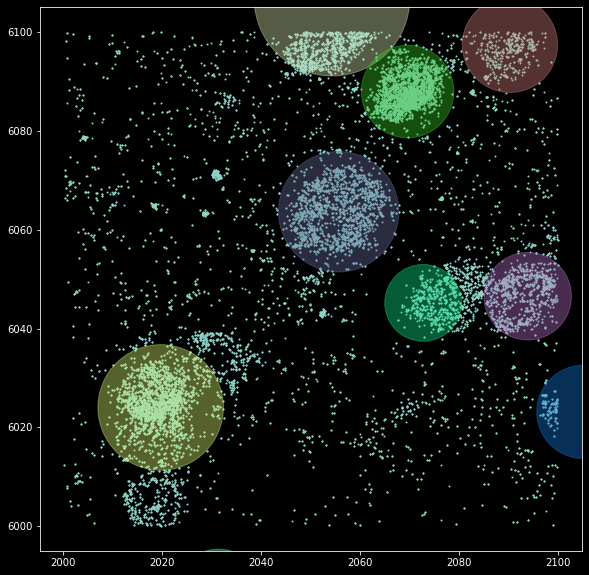

In [25]:
plt.figure(figsize=(10, 10))
plt.scatter(smaller_df['x_um'], smaller_df['y_um'], alpha=1, s=1)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# plt.scatter(df['x_um'], df['y_um'], s=df['radius'])
patches = []
for index, row in df.iterrows():
    patch = matplotlib.patches.Circle((row['x_um'], row['y_um']), row['radius'], color=np.random.rand(3).tolist() + [0.4])
    patches.append(patch)
p = matplotlib.collections.PatchCollection(patches, match_original=True)
ax = plt.gca()
ax.add_collection(p)
ax.set(
    xlim=(df['x_um'].min(), df['x_um'].max()),
    ylim=(df['y_um'].min(), df['y_um'].max())
)
ax.set_aspect('equal')
ax.set(xlim=xlim, ylim=ylim)
plt.show()

### Isolating the expression profile

Let's extract the expression matrix from the table above.

In [44]:
print(df.columns)
gene_columns = df.columns[:df.columns.get_loc('area')]
print(gene_columns)
expression_matrix = df[gene_columns]

Index(['Unnamed: 0.1', 'Unnamed: 0', '1700022I11Rik', '1810046K07Rik',
       '5031425F14Rik', '5730522E02Rik', 'Acta2', 'Adam2', 'Adamts2',
       'Adamts4',
       ...
       'Vwc2', 'Wipf3', 'Wnt7b', 'Zfp804b', 'area', 'position', 'total_reads',
       'simpleClass', 'x_um', 'y_um'],
      dtype='object', length=276)
Index(['Unnamed: 0.1', 'Unnamed: 0', '1700022I11Rik', '1810046K07Rik',
       '5031425F14Rik', '5730522E02Rik', 'Acta2', 'Adam2', 'Adamts2',
       'Adamts4',
       ...
       'Unc5b', 'Unc5d', 'Ust', 'Vip', 'Vipr2', 'Vtn', 'Vwc2', 'Wipf3',
       'Wnt7b', 'Zfp804b'],
      dtype='object', length=270)


In [45]:
expression_matrix

Unnamed: 0.1  Unnamed: 0  1700022I11Rik  1810046K07Rik  5031425F14Rik  \
0                0           0              0              0              0   
1                1           1              0              0              1   
2                2           2              0              0              0   
3                3           3              0              0              0   
4                4           4              0              0              0   
...            ...         ...            ...            ...            ...   
2394          2394        2394              0              0              0   
2395          2395        2395              0              0              0   
2396          2396        2396              0              1              0   
2397          2397        2397              1              0              0   
2398          2398        2398              0              0              0   

      5730522E02Rik  Acta2  Adam2  Adamts2  Adamts4  ...  Unc5b  Unc5d  Ust  \
0                 0      0      0        0        0  ...      0      0    0   
1                 1      0      0        0        0  ...      0      0    1   
2                 1      0      0        0        0  ...      0      0    0   
3                 0      2      0        0        0  ...      0      0    0   
4                 1      0      0        0        2  ...      0      0    1   
...             ...    ...    ...      ...      ...  ...    ...    ...  ...   
2394              0      3      1        0        0  ...      0      1    2   
2395              0      6      1        0        1  ...      1      2    0   
2396              1      3      2        0        3  ...      1      2    2   
2397              0      0      0        0        2  ...      1      0    2   
2398              0      0      0        0        0  ...      0      0    1   

      Vip  Vipr2  Vtn  Vwc2  Wipf3  Wnt7b  Zfp804b  
0     328      0    0     1      0      0        0  
1       0      0    0     9      1      0        1  
2       0      0    0     1      2      0        0  
3      14      0    0     3      0      0        0  
4       4      0    0     4      3      0        1  
...   ...    ...  ...   ...    ...    ...      ...  
2394    2      0    0     3      2      0        0  
2395    6      1    0     1      3      1        1  
2396    2      1    0     8      5      0        0  
2397    4      0    0     2      0      0        0  
2398    2      0    0     3      1      0        1  

[2399 rows x 270 columns]

Let's create an `AnnData` object, for a standard representation of expression data.

In [46]:
adata = ad.AnnData(expression_matrix)
adata

/Users/macbook/miniconda3/envs/day3_python/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 2399 × 270

We also add spatial coordinates.

In [49]:
adata.obsm['x_um'] = df['x_um'].to_numpy()
adata.obsm['y_um'] = df['y_um'].to_numpy()
adata.obsm['radius'] = df['radius'].to_numpy()

If we try to calcuate the quality control metrics we find an error, let's find a solution.

## Analysis of the cell-level spatial data

### Computing quality control metrics

In [50]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

IndexError: Positions outside range of features.

Method one, we can compute our quantities by hand.

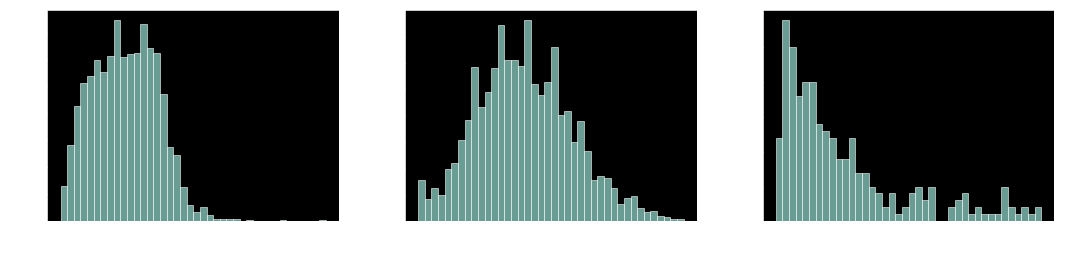

In [51]:
x = adata.X
total_counts = np.sum(x, axis=1)
n_genes_by_count = np.sum(x > 0, axis=1)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(total_counts, kde=False, ax=axes[0], bins=40)
# axes[0].set_yscale('log')
axes[0].set_xlabel('total_counts')
xticks = axes[0].get_xticks()
# print(xticks)
for label in axes[0].get_xticklabels():
    label.set_rotation(45)
# axis[0].set_xticklabels([f'{t:0.2f}' for t in xticks])

sns.histplot(n_genes_by_count, kde=False, ax=axes[1], bins=40)
axes[1].set_xlabel('n_genes_by_count')

sns.histplot(np.sum(x > 0, axis=0), kde=False, ax=axes[2], bins=40)
axes[2].set_xlabel('cells per gene')

plt.tight_layout()
plt.show()

Let's see also if there are genes that are expressed only in a tiny number of cells.

In [33]:
print(sorted(np.sum(x > 0, axis=0)))
np.quantile(np.sum(x > 0, axis=0), q=(0.01, 0.02, 0.05, 0.1))

[11, 24, 29, 36, 38, 42, 47, 48, 50, 56, 58, 68, 72, 75, 76, 78, 80, 88, 89, 90, 90, 91, 93, 94, 94, 95, 97, 100, 100, 101, 108, 109, 112, 112, 114, 114, 119, 123, 125, 126, 127, 132, 134, 135, 137, 138, 139, 141, 146, 147, 148, 149, 151, 155, 157, 161, 164, 164, 168, 169, 173, 175, 178, 184, 188, 188, 197, 198, 204, 218, 221, 224, 224, 225, 227, 231, 234, 234, 234, 235, 235, 235, 242, 246, 255, 258, 261, 261, 262, 264, 264, 272, 276, 287, 291, 292, 292, 298, 298, 299, 299, 306, 306, 309, 312, 316, 326, 330, 339, 339, 340, 340, 341, 342, 349, 353, 354, 356, 356, 356, 357, 360, 365, 368, 373, 384, 386, 389, 391, 398, 398, 402, 404, 404, 423, 424, 428, 428, 437, 447, 454, 456, 458, 463, 463, 464, 467, 469, 479, 481, 481, 492, 492, 499, 504, 508, 516, 525, 531, 537, 541, 545, 546, 550, 551, 559, 561, 572, 572, 582, 602, 606, 617, 625, 632, 641, 646, 651, 653, 653, 666, 678, 687, 688, 693, 701, 707, 715, 717, 722, 724, 724, 727, 732, 733, 740, 740, 763, 766, 771, 804, 818, 825, 825, 829, 8

array([33.69, 43.7 , 75.35, 99.1 ])

From the plot above we can indentify some thresholds for filtering low quality genes and cells. But first let's get back to the bug above and fix it in another way.

In [52]:
%debug

> /Users/macbook/miniconda3/envs/day3_python/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py(397)top_segment_proportions()
    395     # Pretty much just does dispatch
    396     if not (max(ns) <= mtx.shape[1] and min(ns) > 0):
--> 397         raise IndexError("Positions outside range of features.")
    398     if issparse(mtx):
    399         if not isspmatrix_csr(mtx):



ipdb>  mtx


array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 1.000e+00, 0.000e+00, ..., 1.000e+00, 0.000e+00,
        1.000e+00],
       [2.000e+00, 2.000e+00, 0.000e+00, ..., 2.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [2.396e+03, 2.396e+03, 0.000e+00, ..., 5.000e+00, 0.000e+00,
        0.000e+00],
       [2.397e+03, 2.397e+03, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.398e+03, 2.398e+03, 0.000e+00, ..., 1.000e+00, 0.000e+00,
        1.000e+00]], dtype=float32)


ipdb>  ntx.shape


*** NameError: name 'ntx' is not defined


ipdb>  mtx.shape


(2399, 270)


ipdb>  ns


[50, 100, 200, 500]


ipdb>  q


The variable `percent_top`, which by default is set to `(50, 100, 200, 500)` (see [the source code](https://github.com/theislab/scanpy/blob/8fe1cf9cb6309fa0e91aa5cfd9ed7580e9d5b2ad/scanpy/preprocessing/_qc.py#L368)) is the culprit, as we have less than 500 features (we have 270 genes).

In [53]:
sc.pp.calculate_qc_metrics(adata, inplace=True, percent_top=None, log1p=True)

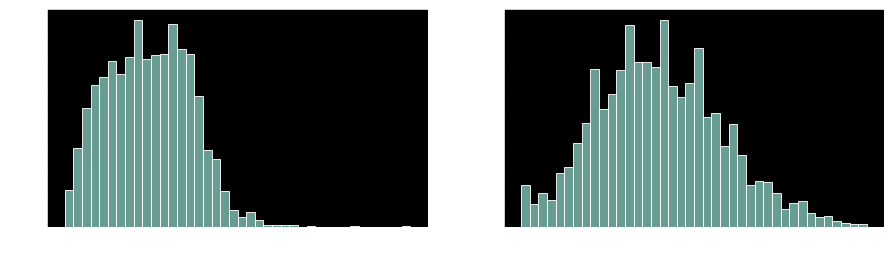

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, bins=40, ax=axs[0])
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=40, ax=axs[1])
plt.show()

### Filtering and preprocessing

Let's proceed with a conservative filtering.

In [55]:
# skipping 
# sc.pp.filter_cells(adata, min_counts= )
sc.pp.filter_cells(adata, min_genes=10)
# skipping
# sc.pp.filter_genes(adata, min_cells= )

Let's divide by the total number of cells, then apply a log-transform and regress out the effect of counts.

In [56]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.regress_out(adata, ['total_counts'])

In [57]:
adata.X

array([[-6.6405573 , -6.6405573 , -0.13118812, ..., -1.1406345 ,
        -0.0433004 , -0.19679323],
       [-4.481667  , -4.481667  , -0.1361809 , ...,  0.946314  ,
        -0.04449309,  1.9072106 ],
       [-3.342642  , -3.342642  , -0.13838784, ...,  2.0535383 ,
        -0.0450203 , -0.20536408],
       ...,
       [-0.09332053, -0.09332053, -0.06794631, ...,  0.45977765,
        -0.02819295, -0.12150762],
       [ 0.26730213,  0.26730213,  0.4319422 , ..., -0.91597867,
        -0.03165003, -0.13873544],
       [ 0.08495669,  0.08495669, -0.07531487, ..., -0.41289103,
        -0.02995318,  0.34008756]], dtype=float32)

### Non-spatial clustering

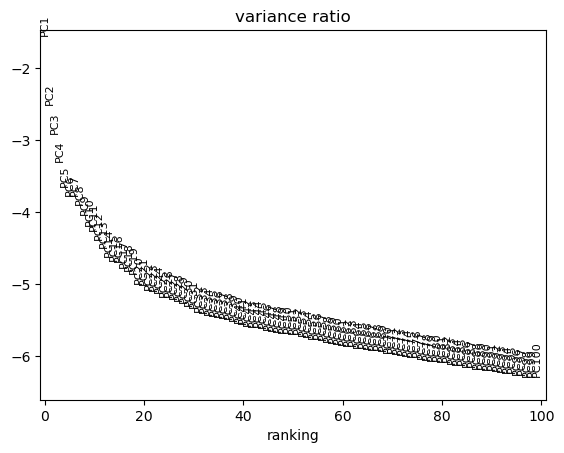

In [58]:
plt.style.use('default')
sc.pp.pca(adata, n_comps=100)
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=100)
plt.style.use('dark_background')

In [59]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=80)
sc.tl.umap(adata)

In [60]:
sc.tl.leiden(adata, random_state=42)

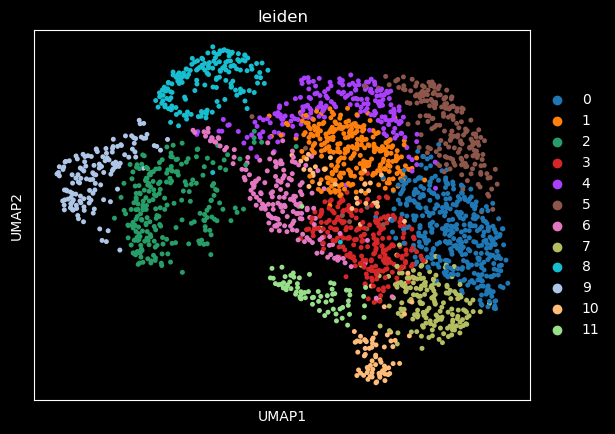

In [61]:
sc.pl.umap(adata, color=['leiden'])

In [62]:
adata

AnnData object with n_obs × n_vars = 2355 × 270
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'x_um', 'y_um', 'radius', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [63]:
adata.obs['leiden']

0        2
1        4
2        1
3        1
4        4
        ..
2394     0
2395    10
2396    10
2397    10
2398    10
Name: leiden, Length: 2355, dtype: category
Categories (12, object): ['0', '1', '2', '3', ..., '8', '9', '10', '11']

In [64]:
adata.uns['leiden_colors']

['#1f77b4',
 '#ff7f0e',
 '#279e68',
 '#d62728',
 '#aa40fc',
 '#8c564b',
 '#e377c2',
 '#b5bd61',
 '#17becf',
 '#aec7e8',
 '#ffbb78',
 '#98df8a']

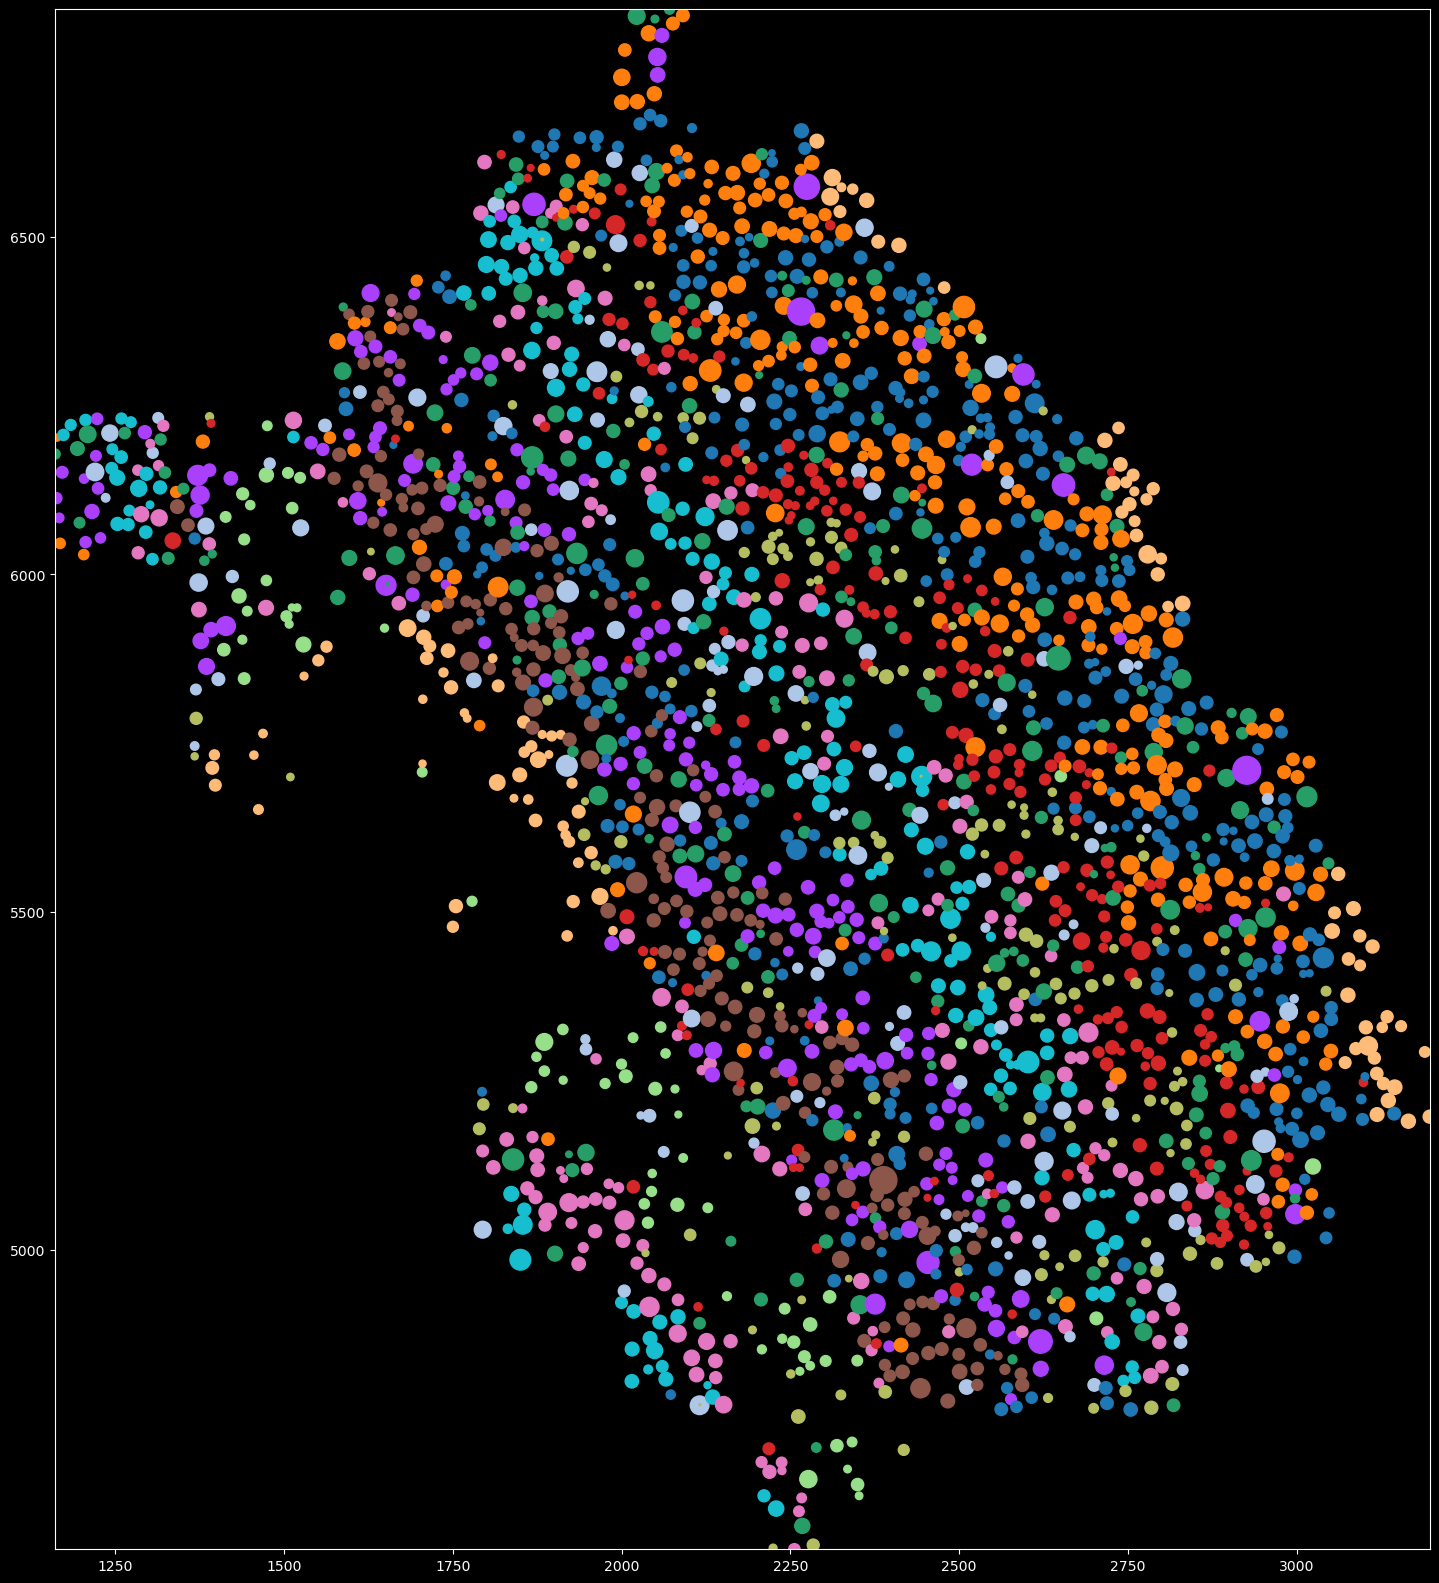

In [65]:
plt.figure(figsize=(20, 20))
# plt.scatter(df['x_um'], df['y_um'], s=df['radius'])
patches = []
for index in adata.obs.index:
    leiden_index = adata[index].obs['leiden']
    hex_color = adata.uns['leiden_colors'][int(leiden_index)]
    rgb_color = matplotlib.colors.to_rgb(hex_color)
    patch = matplotlib.patches.Circle((adata[index].obsm['x_um'], adata[index].obsm['y_um']), adata[index].obsm['radius'], color=rgb_color)
    patches.append(patch)
p = matplotlib.collections.PatchCollection(patches, match_original=True)
ax = plt.gca()
ax.add_collection(p)
ax.set(
    xlim=(df['x_um'].min(), df['x_um'].max()),
    ylim=(df['y_um'].min(), df['y_um'].max())
)
ax.set_aspect('equal')
plt.show()

### Identifying spatial factors of variation with MEFISTO

We first create a MOFA object and set all the required options.

In [66]:
from mofapy2.run.entry_point import entry_point
ent = entry_point()
ent.set_data_options(use_float32=True)
ent.set_data_from_anndata(adata)
N_FACTORS = 4
ent.set_model_options(factors=N_FACTORS)
ent.set_train_options(seed=42)
spatial = np.vstack([adata.obsm["x_um"], adata.obsm["y_um"]]).T
ent.set_covariates(spatial, covariates_names=["x", "y"])
ent.set_smooth_options(sparseGP=True, frac_inducing=0.3, start_opt=10, opt_freq=10)
ent.build()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
use_float32 set to True: replacing float64 arrays by float32 arrays to speed up computations...

Loaded view='rna' group='group1' with N=2355 samples and D=270 features...


Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab pri

We the train the model and save the results. Training takes quite some time, [you can download the trained model here](https://www.dropbox.com/s/hyvmhr4qlso5ihl/ST8059048_MEFISTO.h5?dl=0).

In [68]:
%%time

if False:
    runt.run()
    ent.save("data/MERFISH_MEFISTO.h5")

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.82 µs


The correlation between factors is load, as wished.

<AxesSubplot:>

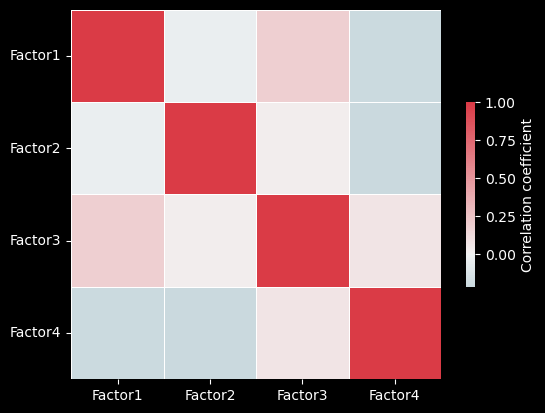

In [69]:
import mofax
m = mofax.mofa_model("data/MERFISH_MEFISTO.h5")
mofax.plot_factors_correlation(m)

In [70]:
adata.obs = adata.obs.join(m.get_factors(df=True))

Let's plot the factors in space

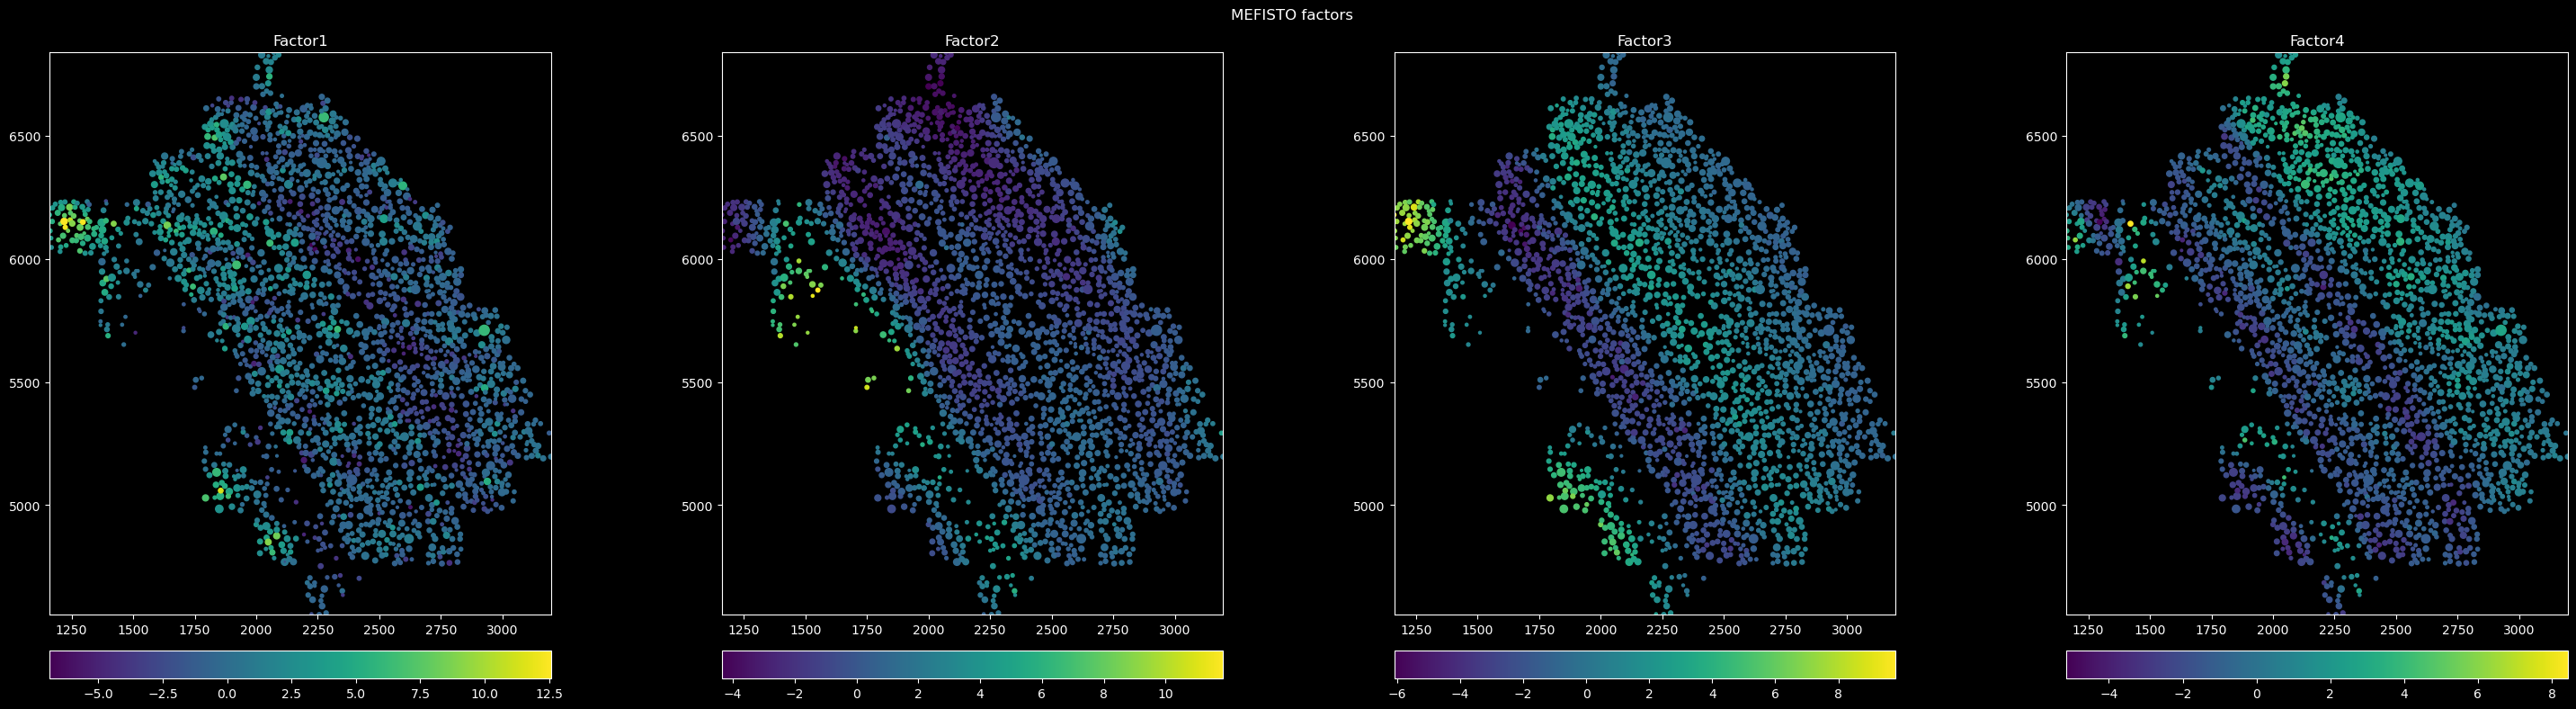

In [71]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(1, N_FACTORS, figsize=(30, 8))
for i in range(0, N_FACTORS):
    name = f'Factor{i + 1}'
    values = adata.obs[name]
    patches = []
    norm = matplotlib.colors.Normalize(vmin=np.min(values), vmax=np.max(values))
#     iii = 0
    for index in adata.obs.index:
#         iii += 1
#         if iii > 10:
#             break
        cmap = matplotlib.cm.get_cmap('viridis')
        rgb_color = cmap(norm(values[index]))
        patch = matplotlib.patches.Circle((adata[index].obsm['x_um'], adata[index].obsm['y_um']), adata[index].obsm['radius'], color=rgb_color)
        patches.append(patch)
    p = matplotlib.collections.PatchCollection(patches, match_original=True)
    axes[i].add_collection(p)
    axes[i].set(
        xlim=(df['x_um'].min(), df['x_um'].max()),
        ylim=(df['y_um'].min(), df['y_um'].max()),
        title=name
    )
    axes[i].set_aspect('equal')
    divider = make_axes_locatable(axes[i])
    ax_cb = divider.new_vertical(size="5%", pad=0.4, pack_start=True)
    cb = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap, norm=norm, orientation='horizontal')
    fig.add_axes(ax_cb)
fig.suptitle('MEFISTO factors')
plt.tight_layout()
plt.show()

Let's look at the fraction of variance attributed to structured spatial variation vs. random noise for each factor:

<AxesSubplot:xlabel='Smoothness', ylabel='Factor'>

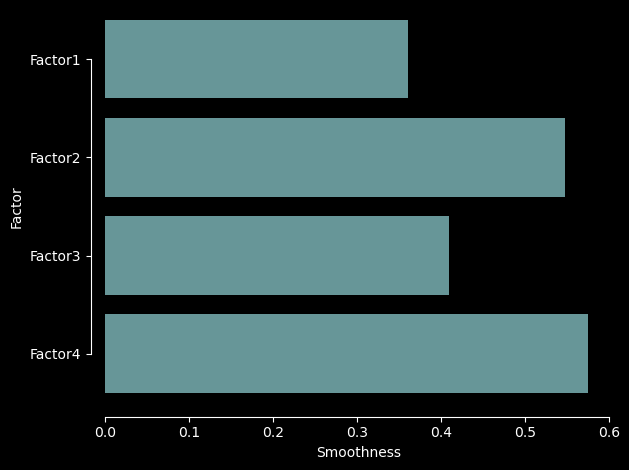

In [73]:
mofax.plot_smoothness(m)

Let's look at the 3 most variable features for Factor4. This time let's rely on the scanpy plotting system.

In [74]:
adata.obsm['spatial'] = spatial
adata.obsm['spatial'][:, 1] = -adata.obsm['spatial'][:, 1]

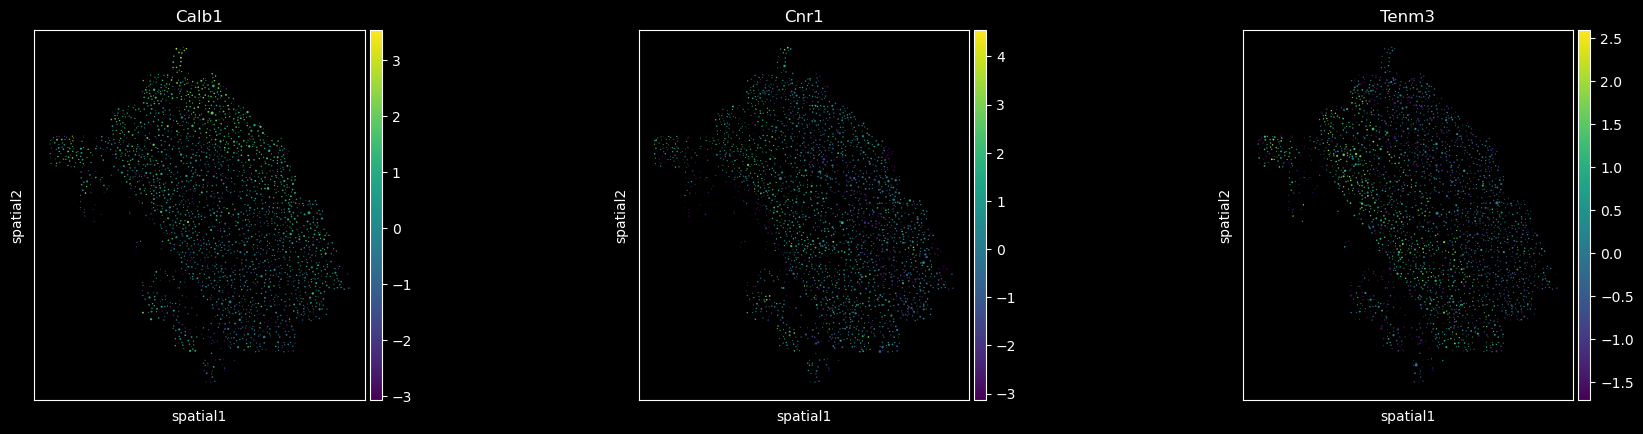

In [75]:
top_features_f2 = m.get_top_features(factors="Factor4", n_features=3)
sc.pl.spatial(adata, color=top_features_f2, spot_size=adata.obsm['radius'])

Let's make a bigger plot. Note the parameter `size=1`. Here one has to be more careful in the matching between the dimensions on the plot and the dimensions in the biological sample. Here we don't care about them matching.

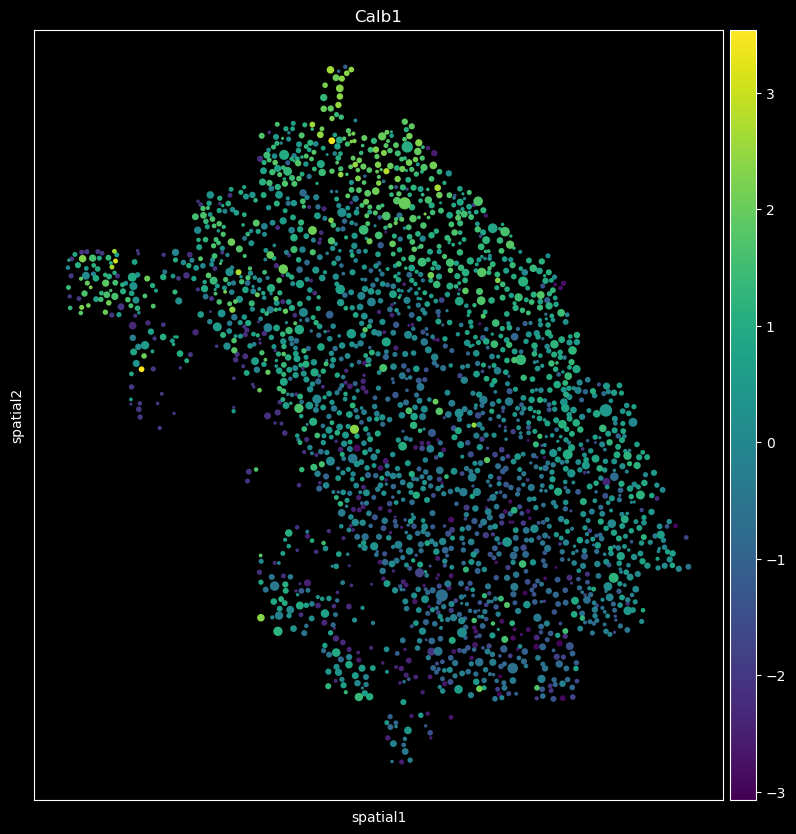

In [85]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
sc.pl.spatial(adata, color=top_features_f2[0], spot_size=adata.obsm['radius'], size=2, ax=ax)

**Extra exercises**
- See the results of MEFISTO with a different number of layers
- Find a way to compare the factors given by MEFISTO to the clusters given by Louvain (if needed you can tweak the MEFISTO and the Louvain parameters)